## Business problem

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
sns.set(style='whitegrid')
import warnings 
warnings.filterwarnings('ignore')
import pandas_profiling
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
import xgboost
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
#Module related to VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Moudles related to feature selection
from sklearn.feature_selection import RFE,f_regression

### Import Data

In [2]:
df=pd.read_csv('E:/DataTrained/Practice_projects/Happiness Score Rank/CountryHappinessRank.csv')

In [3]:
df

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
...,...,...,...,...,...,...,...,...,...,...,...,...
153,Rwanda,Sub-Saharan Africa,154,3.465,0.03464,0.22208,0.77370,0.42864,0.59201,0.55191,0.22628,0.67042
154,Benin,Sub-Saharan Africa,155,3.340,0.03656,0.28665,0.35386,0.31910,0.48450,0.08010,0.18260,1.63328
155,Syria,Middle East and Northern Africa,156,3.006,0.05015,0.66320,0.47489,0.72193,0.15684,0.18906,0.47179,0.32858
156,Burundi,Sub-Saharan Africa,157,2.905,0.08658,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,1.83302


### Data Inspection

In [4]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [5]:
#report=pandas_profiling.ProfileReport(df)
#report

In [6]:
# Checks duplicates records 
df.duplicated().sum()

0

##### There are no duplicated records

In [7]:
# Check Null values
df.isnull().sum()

Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Standard Error                   0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

##### There are no Null records

In [8]:
# Drop Happiness Rank as it is highly correlated with the target feature
df.drop('Happiness Rank',axis=1,inplace=True)

In [10]:
# Drop Country feature due to High Cardinality
df.drop('Country',axis=1,inplace=True)

In [11]:
# Value counts for all the features
for i in df.columns:
    print(df[i].value_counts())
    print('-------------------------')

Sub-Saharan Africa                 40
Central and Eastern Europe         29
Latin America and Caribbean        22
Western Europe                     21
Middle East and Northern Africa    20
Southeastern Asia                   9
Southern Asia                       7
Eastern Asia                        6
North America                       2
Australia and New Zealand           2
Name: Region, dtype: int64
-------------------------
5.192    2
7.587    1
4.686    1
4.839    1
4.800    1
        ..
5.855    1
5.848    1
5.833    1
5.828    1
2.839    1
Name: Happiness Score, Length: 157, dtype: int64
-------------------------
0.03780    2
0.03751    2
0.04394    2
0.05051    2
0.04934    2
          ..
0.04114    1
0.04251    1
0.03843    1
0.05371    1
0.06727    1
Name: Standard Error, Length: 153, dtype: int64
-------------------------
1.39651    1
0.39753    1
1.15406    1
1.02564    1
1.12094    1
          ..
1.12254    1
1.18498    1
1.14723    1
0.59325    1
0.20868    1
Name: Econo

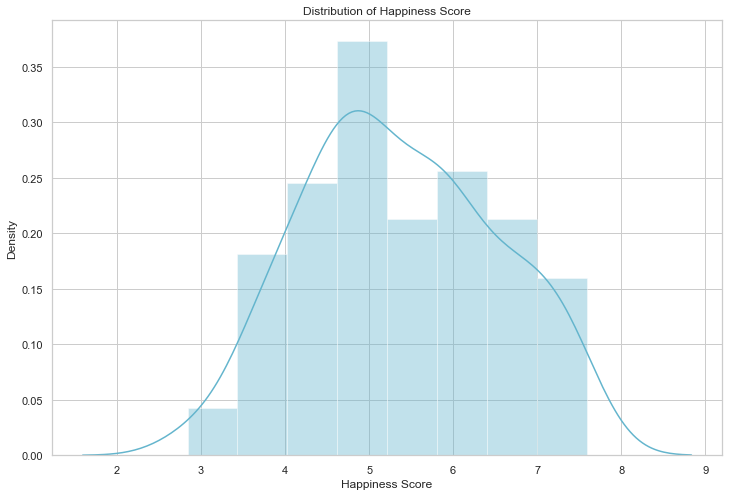

In [13]:
# Looking on the target varaible.
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(df['Happiness Score'], kde = True, color = 'c')
plt.title('Distribution of Happiness Score')
plt.show()

###### It's a Normal Distribution

In [14]:
# split the data to continous and categorical data.
num_vars=df.select_dtypes(['int64','float64'])
cat_vars=df.select_dtypes(['object'])

In [15]:
# Descriptive analysis for numerical variables.
num_vars.apply(continuous_var_summary)

,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
N,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SUM,849.366000,7.565790,133.689680,156.585260,99.580980,67.721160,22.660650,37.492690,331.638330
MEAN,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
MEDIAN,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
STD,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
VAR,1.311048,0.000294,0.162506,0.074185,0.061047,0.022708,0.014408,0.016049,0.306417
MIN,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
P1,2.962570,0.019669,0.015722,0.232803,0.058721,0.085802,0.004675,0.015909,0.663484
P5,3.655850,0.031036,0.186325,0.415606,0.151588,0.170474,0.015823,0.071195,1.236587


In [16]:
# Descriptive analysis for categorical variables.
cat_vars.describe()

,Region
count,158
unique,10
top,Sub-Saharan Africa
freq,40


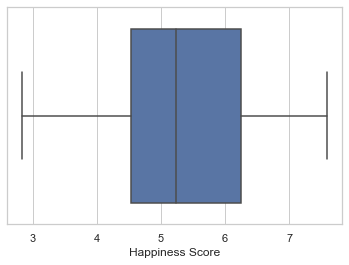

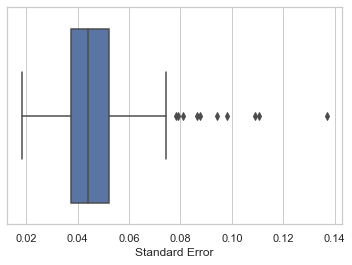

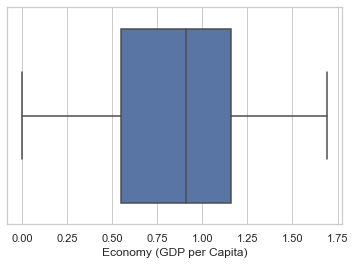

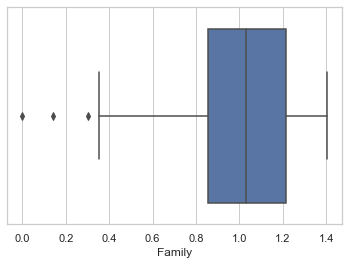

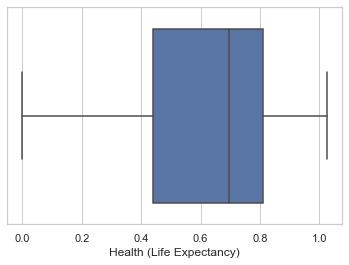

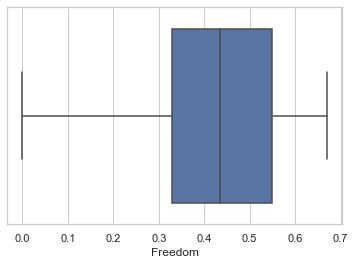

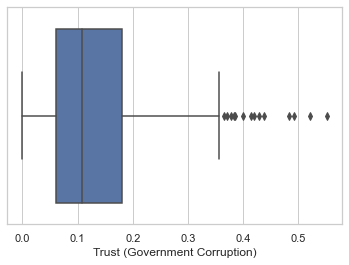

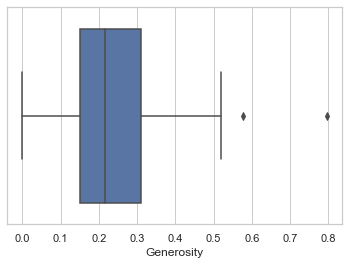

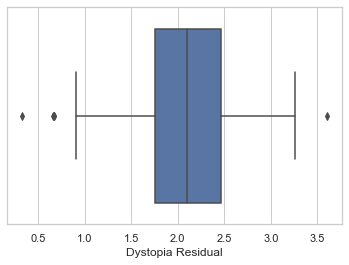

In [17]:
# Outlier treatment 
for col in num_vars.columns:
    sns.boxplot(num_vars[col])
    plt.show()

In [18]:
# I'll use clip so data loss is  2% instead of using IQR which data loss=(20/158) = 12% as Data is not big.

# Removing outliers
num_vars= num_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [19]:
num_vars.apply(continuous_var_summary).round(2)

,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
N,158.00,158.00,158.00,158.00,158.00,158.00,158.00,158.00,158.00
NMISS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SUM,849.48,7.54,133.57,156.87,99.61,67.81,22.60,37.24,331.56
MEAN,5.38,0.05,0.85,0.99,0.63,0.43,0.14,0.24,2.10
MEDIAN,5.23,0.04,0.91,1.03,0.70,0.44,0.11,0.22,2.10
STD,1.14,0.02,0.40,0.27,0.25,0.15,0.12,0.12,0.54
VAR,1.30,0.00,0.16,0.07,0.06,0.02,0.01,0.01,0.29
MIN,2.96,0.02,0.02,0.23,0.06,0.09,0.00,0.02,0.66
P1,2.99,0.02,0.02,0.27,0.06,0.09,0.01,0.02,0.67
P5,3.66,0.03,0.19,0.42,0.15,0.17,0.02,0.07,1.24


-------------------------------------------------------------------------------------------------------------------------------

In [20]:
df_eda=pd.concat([num_vars,cat_vars],axis=1)
df_eda

,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Region
0,7.54162,0.03411,1.396510,1.349510,0.94143,0.663797,0.419780,0.29678,2.517380,Western Europe
1,7.54162,0.04884,1.302320,1.364407,0.94784,0.628770,0.141450,0.43630,2.702010,Western Europe
2,7.52700,0.03328,1.325480,1.360580,0.87464,0.649380,0.483570,0.34139,2.492040,Western Europe
3,7.52200,0.03880,1.459000,1.330950,0.88521,0.663797,0.365030,0.34699,2.465310,Western Europe
4,7.42700,0.03553,1.326290,1.322610,0.90563,0.632970,0.329570,0.45811,2.451760,North America
...,...,...,...,...,...,...,...,...,...,...
153,3.46500,0.03464,0.222080,0.773700,0.42864,0.592010,0.504991,0.22628,0.670420,Sub-Saharan Africa
154,3.34000,0.03656,0.286650,0.353860,0.31910,0.484500,0.080100,0.18260,1.633280,Sub-Saharan Africa
155,3.00600,0.05015,0.663200,0.474890,0.72193,0.156840,0.189060,0.47179,0.663484,Middle East and Northern Africa
156,2.96257,0.08658,0.015722,0.415870,0.22396,0.118500,0.100620,0.19727,1.833020,Sub-Saharan Africa


## EDA

##### Univariate analysis

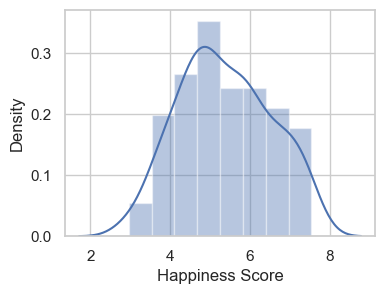

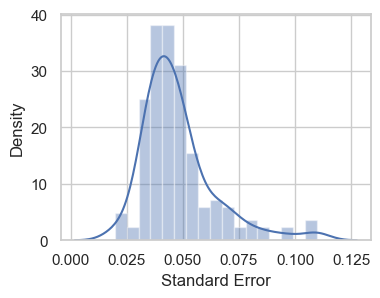

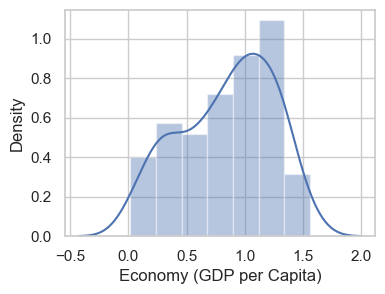

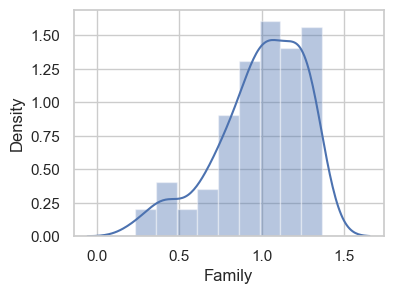

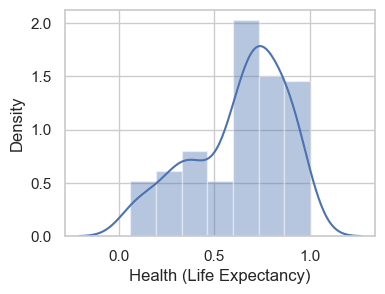

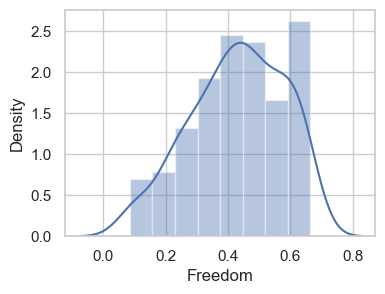

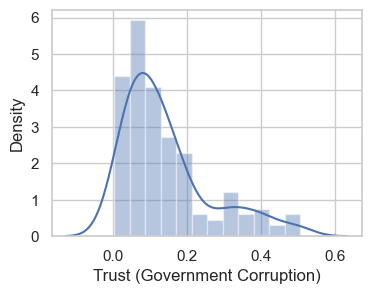

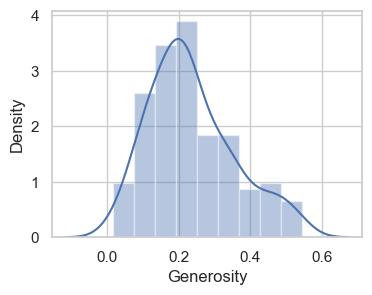

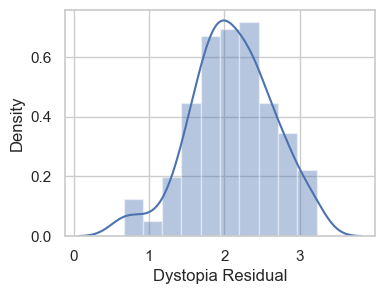

In [22]:
for col in num_vars.columns:
    plt.figure(figsize=(4,3),dpi=100)
    sns.distplot(df_eda[col])
    plt.show()

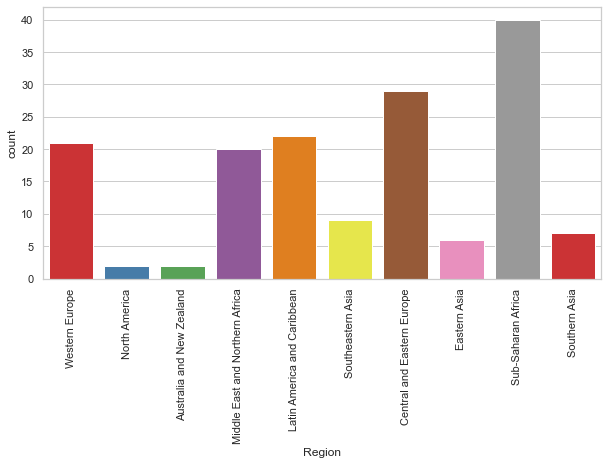

In [36]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df_eda,
    x='Region',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
None

In [ ]:
# Sub-Saharan Africa is the most region having countries (40) in the Happiness rank then Central and Eastern Europe with 29.
# Trust (Government Corruption), Standard Error & Family are skewed

#### Bivariate analysis

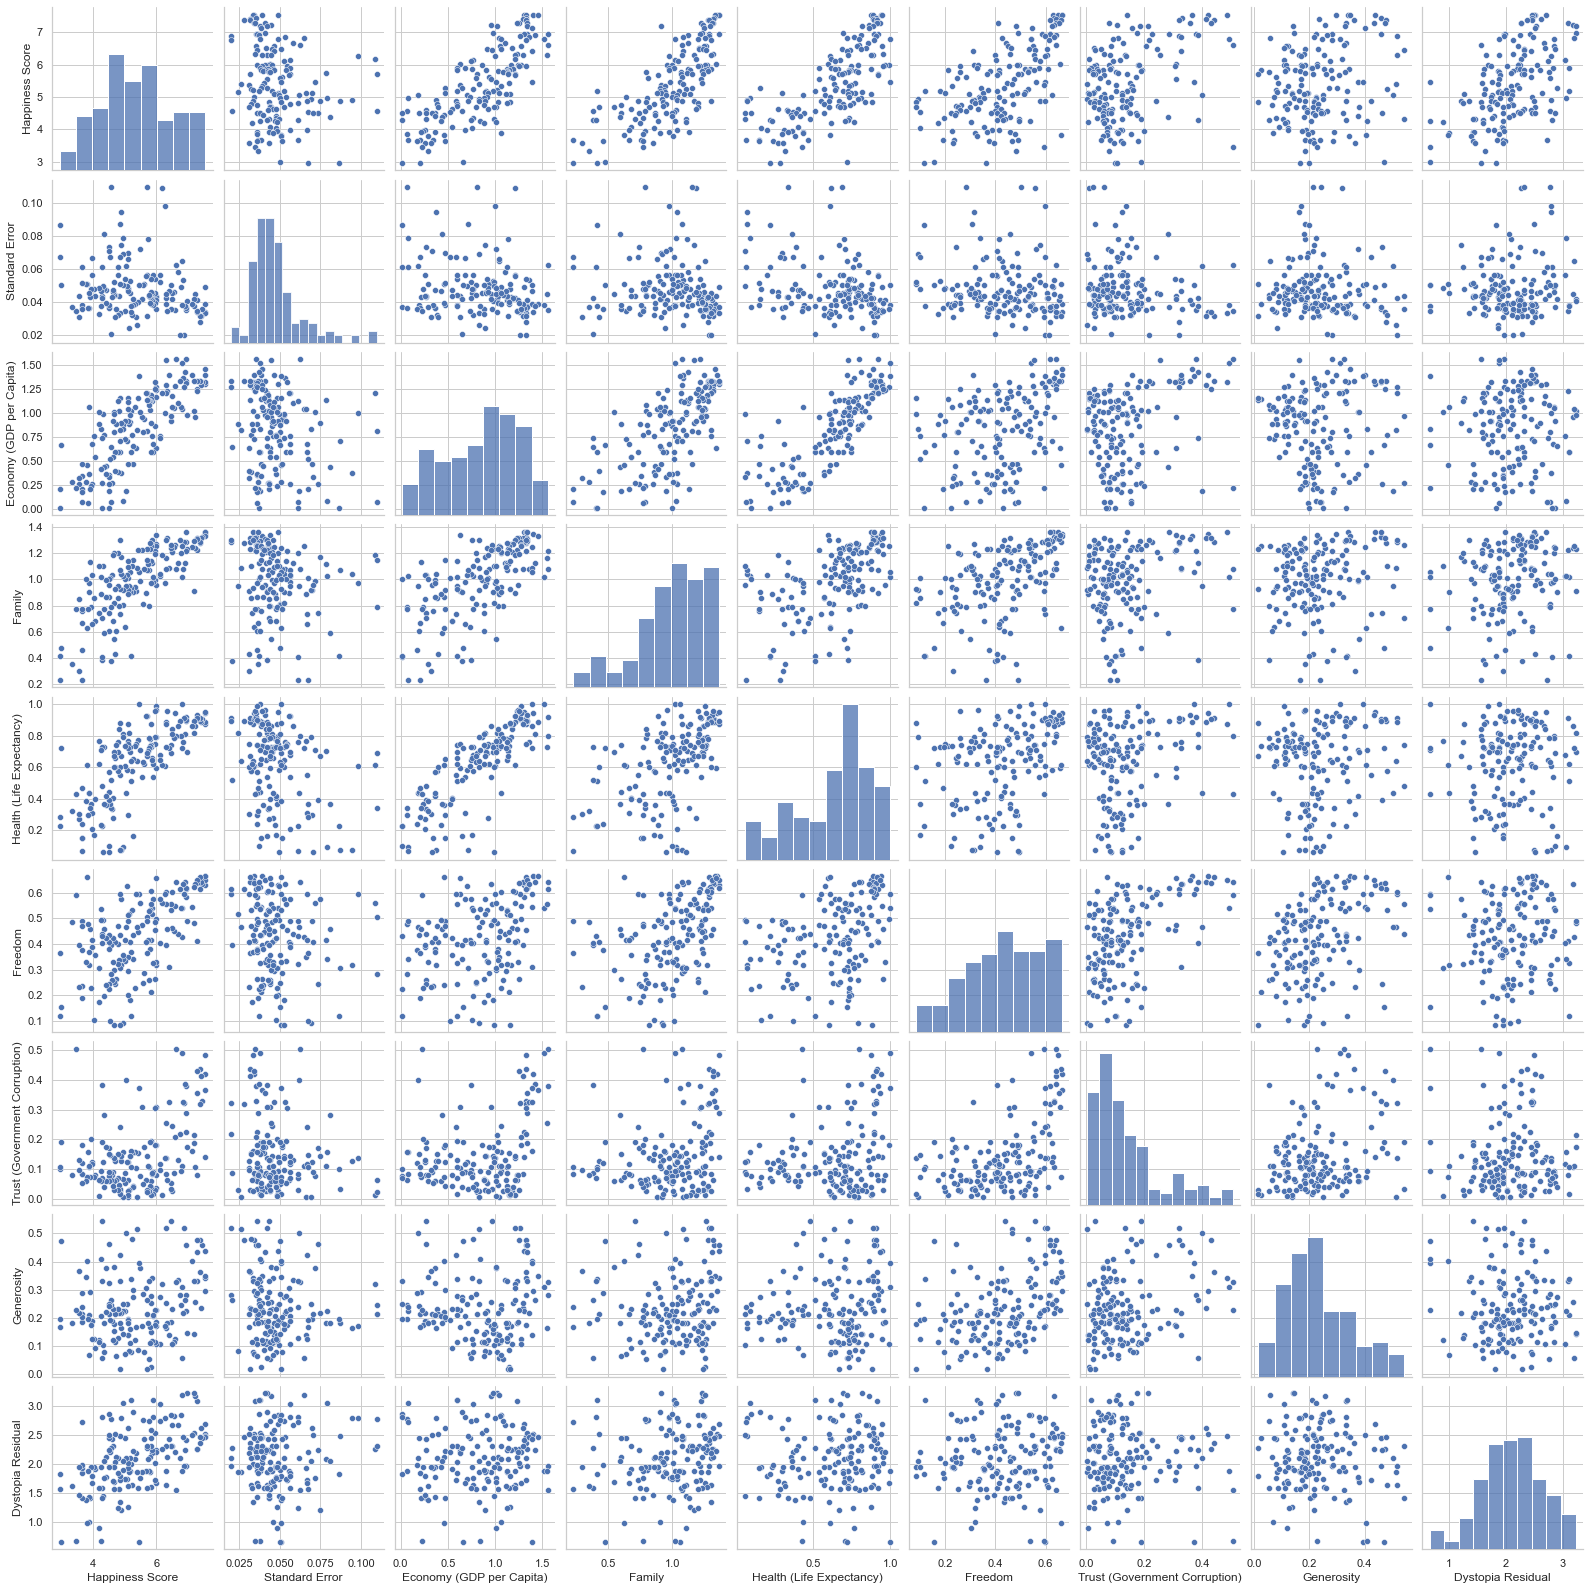

In [38]:
sns.pairplot(df_eda)
plt.show()

In [41]:
# Charges & smoker
fig=px.histogram(df_eda,x='Happiness Score',color='Region',title='Happiness Score')
fig.update_layout(bargap=0.1)
fig.show()

In [42]:
df_eda.columns

Index(['Happiness Score', 'Standard Error', 'Economy (GDP per Capita)',
       'Family', 'Health (Life Expectancy)', 'Freedom',
       'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual',
       'Region'],
      dtype='object')

In [48]:
# Economy & Health
fig=px.scatter(df_eda,x='Economy (GDP per Capita)',y='Health (Life Expectancy)',color='Happiness Score',hover_name='Happiness Score',opacity=0.8,title='Economy Vs Health')
fig.update_traces(marker_size=5)
fig.show()

In [49]:
# Family & Happiness Score
fig=px.scatter(df_eda,x='Family',y='Happiness Score',color='Region',hover_name='Region',opacity=0.8,title='Family Vs Hapiness Score')
fig.update_traces(marker_size=5)
fig.show()

In [51]:
# Happiness Score & Health
fig=px.scatter(df_eda,x='Happiness Score',y='Health (Life Expectancy)',color='Region',hover_name='Region',opacity=0.8,title='Health Vs Hapiness Score')
fig.update_traces(marker_size=5)
fig.show()

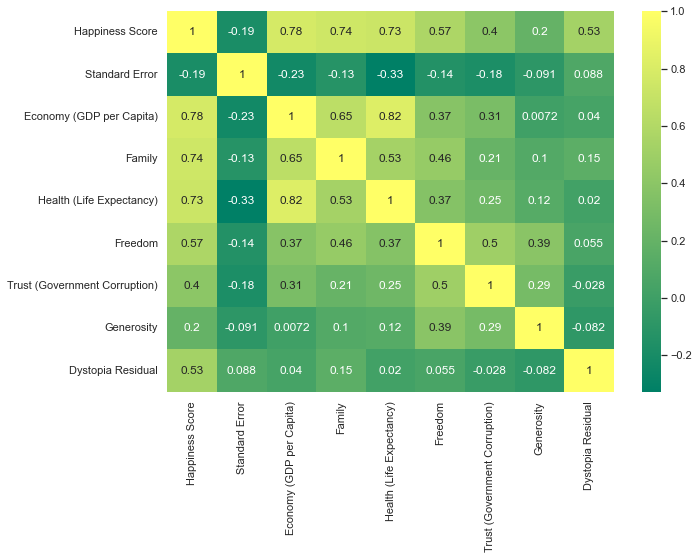

In [52]:
# heatmap
plt.figure(figsize = (10,7))
sns.heatmap(df_eda.corr(), annot=True,cmap='summer')
plt.show()

In [ ]:
# There are a strong postive correlation between Economy,Health & Family with target feature (Happiness Score)
# Western Europe & North America both regions have most high countries in Happiness Score
# Sub-Saharan Africa Southern Asia have most lowest countries in Happiness Score 

-------------------------------------------------------------------------------------------------------------------------------

In [53]:
# Apply get dummies for categorical features
df_final = pd.get_dummies(df_eda,['Region'], drop_first=True)

In [54]:
df_final

,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Region_Central and Eastern Europe,Region_Eastern Asia,Region_Latin America and Caribbean,Region_Middle East and Northern Africa,Region_North America,Region_Southeastern Asia,Region_Southern Asia,Region_Sub-Saharan Africa,Region_Western Europe
0,7.54162,0.03411,1.396510,1.349510,0.94143,0.663797,0.419780,0.29678,2.517380,0,0,0,0,0,0,0,0,1
1,7.54162,0.04884,1.302320,1.364407,0.94784,0.628770,0.141450,0.43630,2.702010,0,0,0,0,0,0,0,0,1
2,7.52700,0.03328,1.325480,1.360580,0.87464,0.649380,0.483570,0.34139,2.492040,0,0,0,0,0,0,0,0,1
3,7.52200,0.03880,1.459000,1.330950,0.88521,0.663797,0.365030,0.34699,2.465310,0,0,0,0,0,0,0,0,1
4,7.42700,0.03553,1.326290,1.322610,0.90563,0.632970,0.329570,0.45811,2.451760,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,3.46500,0.03464,0.222080,0.773700,0.42864,0.592010,0.504991,0.22628,0.670420,0,0,0,0,0,0,0,1,0
154,3.34000,0.03656,0.286650,0.353860,0.31910,0.484500,0.080100,0.18260,1.633280,0,0,0,0,0,0,0,1,0
155,3.00600,0.05015,0.663200,0.474890,0.72193,0.156840,0.189060,0.47179,0.663484,0,0,0,1,0,0,0,0,0
156,2.96257,0.08658,0.015722,0.415870,0.22396,0.118500,0.100620,0.19727,1.833020,0,0,0,0,0,0,0,1,0


### Variable Reduction

#### RFE

In [56]:
X = df_final[df_final.columns.difference(['Happiness Score'])]
y = df_final['Happiness Score']

In [63]:
rfe = RFE(LinearRegression(), n_features_to_select=10).fit(X,y)

In [64]:
l1_rfe = X.columns[rfe.get_support()]

In [65]:
l1_rfe

Index(['Dystopia Residual', 'Economy (GDP per Capita)', 'Family', 'Freedom',
       'Generosity', 'Health (Life Expectancy)',
       'Region_Latin America and Caribbean', 'Region_Southeastern Asia',
       'Standard Error', 'Trust (Government Corruption)'],
      dtype='object')

#### F-regression

In [74]:
F_values, p_values  = f_regression(X, y )

In [75]:
import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(X.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])

In [76]:
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results = f_reg_results.sort_values(by=['P_Value'])

In [77]:
f_reg_results

,Variable,F_Value,P_Value
0,Dystopia Residual,60.122446,0.000
14,Region_Western Europe,39.758682,0.000
13,Region_Sub-Saharan Africa,86.883589,0.000
5,Health (Life Expectancy),174.205168,0.000
16,Trust (Government Corruption),30.270936,0.000
3,Freedom,75.651061,0.000
2,Family,193.391319,0.000
1,Economy (GDP per Capita),245.739044,0.000
8,Region_Latin America and Caribbean,12.412093,0.001
4,Generosity,6.539367,0.012


In [78]:
l2_fr=f_reg_results[:13]['Variable'].values

In [79]:
l2_fr

array(['Dystopia Residual', 'Region_Western Europe',
       'Region_Sub-Saharan Africa', 'Health (Life Expectancy)',
       'Trust (Government Corruption)', 'Freedom', 'Family',
       'Economy (GDP per Capita)', 'Region_Latin America and Caribbean',
       'Generosity', 'Region_North America', 'Standard Error',
       'Region_Southern Asia'], dtype=object)

In [80]:
list(set(list(l1_rfe)+list(l2_fr)))

['Generosity',
 'Family',
 'Region_Western Europe',
 'Region_Southern Asia',
 'Health (Life Expectancy)',
 'Dystopia Residual',
 'Standard Error',
 'Economy (GDP per Capita)',
 'Freedom',
 'Trust (Government Corruption)',
 'Region_Southeastern Asia',
 'Region_North America',
 'Region_Sub-Saharan Africa',
 'Region_Latin America and Caribbean']

In [106]:
final_list= ['Region_Western Europe',
 #'Family',
 #'Generosity',
 'Region_Southern Asia',
 #'Health (Life Expectancy)',
 #'Dystopia Residual',
 #'Standard Error',
 'Economy (GDP per Capita)',
 #'Freedom',
 'Trust (Government Corruption)',
 'Region_Southeastern Asia',
 'Region_North America',
 'Region_Sub-Saharan Africa',
 'Region_Latin America and Caribbean']

-------------------------------------------------------------------------------------------------------------------------------

#### VIF check Multicollinarity

In [107]:
X_new = X[final_list]
y = y

In [108]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns

In [109]:
vif.sort_values(by='VIF_Factor', ascending=False, inplace=True)
vif

,VIF_Factor,features
2,3.233991,Economy (GDP per Capita)
3,2.897689,Trust (Government Corruption)
0,1.562507,Region_Western Europe
7,1.246887,Region_Latin America and Caribbean
6,1.200170,Region_Sub-Saharan Africa
4,1.093801,Region_Southeastern Asia
5,1.059065,Region_North America
1,1.035510,Region_Southern Asia


-------------------------------------------------------------------------------------------------------------------------------

## ML Algos

In [111]:
x=df_final.drop('Happiness Score',axis=1)
y=df_final['Happiness Score']

In [112]:
lr=LinearRegression()
for i in range(0,100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=i,test_size=0.2)
    lr.fit(x_train,y_train)
    pred_train=lr.predict(x_train)
    pred_test=lr.predict(x_test)
    if round(r2_score(pred_train,y_train)*100,1)==round(r2_score(y_test,pred_test)*100,1):
        print("At random state ",i," The model performs very well")
        print("At random_state: ",i)
        print("Training R2_score is :-",round(r2_score(y_train,pred_train)*100,1))
        print("Testing R2_score is:-",round(r2_score(y_test,pred_test)*100,1),  '\n\n')

At random state  18  The model performs very well
At random_state:  18
Training R2_score is :- 99.8
Testing R2_score is:- 99.8 


At random state  27  The model performs very well
At random_state:  27
Training R2_score is :- 99.8
Testing R2_score is:- 99.8 


At random state  45  The model performs very well
At random_state:  45
Training R2_score is :- 99.8
Testing R2_score is:- 99.8 


At random state  54  The model performs very well
At random_state:  54
Training R2_score is :- 99.8
Testing R2_score is:- 99.8 


At random state  56  The model performs very well
At random_state:  56
Training R2_score is :- 99.8
Testing R2_score is:- 99.8 


At random state  62  The model performs very well
At random_state:  62
Training R2_score is :- 99.8
Testing R2_score is:- 99.8 


At random state  67  The model performs very well
At random_state:  67
Training R2_score is :- 99.8
Testing R2_score is:- 99.8 


At random state  73  The model performs very well
At random_state:  73
Training R2_score i

### splitting the data

In [113]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=18)

### Standarization of data.

In [114]:
sc=StandardScaler()
x_train_sc=sc.fit_transform(x_train)
x_test_sc=sc.transform(x_test)

### Linear Regression

In [115]:
lr=LinearRegression()
lr.fit(x_train_sc,y_train)
pred=lr.predict(x_test_sc)
score=r2_score(y_test,pred)
mse = mean_squared_error(y_test, pred)
print('R2_Score: ',score)
print('RMSE = ', np.sqrt(mse).round(4))

R2_Score:  0.9982284231299418
RMSE =  0.0495


### Cross validation of the Model

In [116]:
for i in(2,10):
    cv_score=cross_val_score(lr,x,y,cv=i)
    cv_mean= cv_score.mean()
    print(f'At Cross fold {i} the cv score is {cv_mean} , testing accuracy score= {score}')
    print('\n')

At Cross fold 2 the cv score is 0.9891632138465365 , testing accuracy score= 0.9982284231299418


At Cross fold 10 the cv score is 0.8827195515845295 , testing accuracy score= 0.9982284231299418




###### chose cv=2

##### Polynominal

In [122]:
poly=PolynomialFeatures(degree=3)
xtrain_poly=poly.fit_transform(x_train_sc)
xtest_poly=poly.transform(x_test_sc)

In [123]:
lr2=LinearRegression()
lr2.fit(xtrain_poly,y_train)

LinearRegression()

In [124]:
pred_train=lr2.predict(xtrain_poly)
pred_test=lr2.predict(xtest_poly)

In [125]:
r2_train = r2_score(y_train, pred_train)
print('The train R-square value is: ', r2_train.round(4))

The train R-square value is:  1.0


In [126]:
r2_test = r2_score(y_test, pred_test)
print('The test R-square value is: ', r2_test.round(4))

The test R-square value is:  0.9261


In [127]:
mse = mean_squared_error(y_test, pred_test)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.3196


In [128]:
# try Rideg and Lasso Regularization to prevent overfitting with polynomial degree=3

In [129]:
# Using Lasso regularization
tuned_parameters = [{'alpha': [0.0001,0.001,0.01,0.1,1.]}]

LassoCV = GridSearchCV(Lasso(),
                   tuned_parameters,
                   cv=2,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error',
                   verbose=10)

LassoCV.fit(xtrain_poly,y_train)

print('Best combination:', LassoCV.best_params_);

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best combination: {'alpha': 0.0001}


In [130]:
Lasso=Lasso(alpha=0.0001)
lasso_model=Lasso.fit(xtrain_poly,y_train)

train_pred=lasso_model.predict(xtrain_poly)
test_pred=lasso_model.predict(xtest_poly)

In [131]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  1.0


In [132]:
r_squared = r2_score(y_test, test_pred)
print('The test R-square value is: ', r_squared.round(4))

The test R-square value is:  0.9942


In [133]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.0896


In [134]:
# Using Ridge regularization
tuned_parameters = [{'alpha': [0.01,0.1,1.,5,10.,30.,20.,50.0]}]

RidgeCV = GridSearchCV(Ridge(),
                   tuned_parameters,
                   cv=2,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error',
                   verbose=10)

RidgeCV.fit(xtrain_poly,y_train)

print('Best combination:', RidgeCV.best_params_);

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best combination: {'alpha': 0.01}


In [135]:
Ridge=Ridge(alpha=0.01)
ridge_model=Ridge.fit(xtrain_poly,y_train)

train_pred=ridge_model.predict(xtrain_poly)
test_pred=ridge_model.predict(xtest_poly)

In [136]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  1.0


In [137]:
r_squared = r2_score(y_test, test_pred)
print('The test R-square value is: ', r_squared.round(4))

The test R-square value is:  0.9263


In [138]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.3192


------------------------------------------------------------------------------------------------------------------------------

### KNN

In [140]:
knn=KNeighborsRegressor()

In [141]:
knn_params={'n_neighbors':[5,7,9,11],'weights':['distance','uniform'],'metric':['manhatten','euclidean']}
knn_model= GridSearchCV(knn,knn_params,cv=2,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


In [142]:
knn_model.best_params_

{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

In [143]:
knn_model = KNeighborsRegressor(n_neighbors=9, weights='distance',metric='euclidean').fit(x_train_sc, y_train)

In [144]:
train_pred=knn_model.predict(x_train_sc)
test_pred=knn_model.predict(x_test_sc)

In [145]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  1.0


In [146]:
r_squared = r2_score(y_test, test_pred)
print('The test R-square value is: ', r_squared.round(4))

The test R-square value is:  0.8195


In [147]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.4995


-----------------------------------------------------------------------------------------------------------------------------

### SVM

In [150]:
svr=SVR()

In [151]:
svr_params={'C':[1,5,10,15,20,30,50],'gamma':[0.001,0.01,0.1,0.2,0.3],'epsilon':[0.01,0.1,1.0]}

In [152]:
svr_model=GridSearchCV(svr,svr_params,cv=2,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 2 folds for each of 105 candidates, totalling 210 fits


In [153]:
svr_model.best_params_

{'C': 30, 'epsilon': 0.01, 'gamma': 0.001}

In [154]:
svr_model=svr_model.best_estimator_

In [155]:
train_pred=svr_model.predict(x_train_sc)
test_pred=svr_model.predict(x_test_sc)

In [156]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.9979


In [157]:
r_squared = r2_score(y_test, test_pred)
print('The test R-square value is: ', r_squared.round(4))

The test R-square value is:  0.9984


In [158]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.0472


-------------------------------------------------------------------------------------------------------------------------------

### DT

In [159]:
dtr=DecisionTreeRegressor()

In [160]:
dt_params={'max_depth': np.arange(3,13),'min_samples_split':range(3,11),'min_samples_leaf':range(2,9),
           'max_features': np.arange(4,7)}

In [161]:
dt_model=GridSearchCV(dtr,dt_params,cv=2,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 2 folds for each of 1680 candidates, totalling 3360 fits


In [162]:
dt_model.best_params_

{'max_depth': 11,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10}

In [163]:
dt_model=dt_model.best_estimator_

In [164]:
train_pred=dt_model.predict(x_train_sc)
test_pred=dt_model.predict(x_test_sc)

In [165]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.8286


In [166]:
r_squared = r2_score(y_test, test_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.6826


In [167]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.6624


-------------------------------------------------------------------------------------------------------------------------------

## Ensembles Techniques

### Bagging : RandomForest

In [168]:
rfr=RandomForestRegressor()

In [169]:
rf_params={'n_estimators': [70,100,200,400,600],'max_depth':range(2,13),'max_features':['auto','sqrt']}

In [170]:
rf_model=GridSearchCV(rfr,rf_params,cv=2,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 2 folds for each of 110 candidates, totalling 220 fits


In [171]:
rf_model.best_params_

{'max_depth': 11, 'max_features': 'auto', 'n_estimators': 200}

In [172]:
rf_model=rf_model.best_estimator_

In [173]:
train_pred=rf_model.predict(x_train_sc)
test_pred=rf_model.predict(x_test_sc)

In [174]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.9859


In [175]:
r_squared = r2_score(y_test, test_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.9367


In [176]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.2959


------------------------------------------------------------------------------------------------------------------------------

### Boosting

##### AdaBoostRegressor

In [177]:
adar=AdaBoostRegressor()

In [189]:
ada_params={'n_estimators': [150,200,250,300,400,500,700,800,1000],'learning_rate': [10 ** x for x in range(-4, 3)]}

In [190]:
ada_model=GridSearchCV(adar,ada_params,cv=2,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 2 folds for each of 63 candidates, totalling 126 fits


In [191]:
ada_model.best_params_

{'learning_rate': 1, 'n_estimators': 300}

In [192]:
ada_model=ada_model.best_estimator_

In [193]:
train_pred=rf_model.predict(x_train_sc)
test_pred=rf_model.predict(x_test_sc)

In [194]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.9859


In [195]:
r_squared = r2_score(y_test, test_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.9367


In [196]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.2959


--------------------------------------------------------------------------------------------------------------------------------

##### GradientBoost

In [197]:
gbr=GradientBoostingRegressor()

In [198]:
gb_params={'n_estimators': [100,300,500,700,1000],'max_depth':[2,3,4,5,7,8],'learning_rate': [10 ** x for x in range(-4, 3)]}


In [199]:
gb_model=GridSearchCV(gbr,gb_params,cv=2,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 2 folds for each of 210 candidates, totalling 420 fits


In [200]:
gb_model.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}

In [201]:
gb_model=gb_model.best_estimator_

In [202]:
train_pred=gb_model.predict(x_train_sc)
test_pred=gb_model.predict(x_test_sc)

In [203]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  1.0


In [204]:
r_squared = r2_score(y_test, test_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.9674


In [205]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.2123


-------------------------------------------------------------------------------------------------------------------------------

##### XGBOOST

In [207]:
xgb=xgboost.XGBRegressor()

In [208]:
xgb_params={ 'learning_rate':[0.01,0.1,0.15,0.3],'n_estimators':[50,100,200,500,800,1000,1200],'max_depth':[2,3,4,5,6,7]}

In [209]:
xgb_model=GridSearchCV(xgb,xgb_params,cv=2,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 2 folds for each of 168 candidates, totalling 336 fits


In [210]:
xgb_model.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 800}

In [211]:
xgb_model= xgb_model.best_estimator_

In [212]:
train_pred=xgb_model.predict(x_train_sc)
test_pred=xgb_model.predict(x_test_sc)

In [213]:
r_squared = r2_score(y_train, train_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  1.0


In [214]:
r_squared = r2_score(y_test, test_pred)
print('The train R-square value is: ', r_squared.round(4))

The train R-square value is:  0.9628


In [215]:
mse = mean_squared_error(y_test, test_pred)

print('RMSE = ', np.sqrt(mse).round(4))

RMSE =  0.2267


-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

### Saving the Model

In [216]:
#Saving the model using .pkl
import joblib
joblib.dump(svr_model,"Happiness_Score.pkl")

['Happiness_Score.pkl']

In [217]:
#Loading the saved model
aa=joblib.load("Happiness_Score.pkl")

In [218]:
#Prediction
prediction = aa.predict(x_test_sc)
prediction

array([4.50628175, 7.38020196, 7.20780501, 6.94656354, 6.94756153,
       4.62229199, 6.25879669, 4.58047869, 5.77320644, 6.79021635,
       6.49976123, 6.1462391 , 4.07495188, 7.5901733 , 6.13518124,
       4.94051996, 5.98385118, 5.05932728, 4.66650949, 5.10581159,
       5.81288505, 3.9260993 , 5.94035353, 5.2870012 , 2.96130498,
       4.37429882, 5.83797624, 6.41060566, 5.18352397, 3.61313471,
       5.96732026, 3.89503594])

In [219]:
pd.DataFrame([np.exp(aa.predict(x_test_sc)[:]),np.exp(y_test[:])],index=["Predicted","Original"])

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Predicted,90.584376,1603.913656,1349.925944,1039.571134,1040.609142,101.726923,522.589723,97.561084,321.567169,889.105903,...,380.069271,197.749524,19.323172,79.384158,343.084316,608.261967,178.310064,37.082112,390.457940,49.157820
Original,91.103844,1680.757729,1339.430764,1029.676547,1032.770215,102.822068,527.949165,96.640702,320.537733,885.365009,...,382.986599,197.551636,19.347631,78.964628,339.678642,635.873726,179.827849,35.694621,387.610124,49.205234


### Done with Pleasure